In [1]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig, create_optimizer
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

/Users/matthewieraci/.pyenv/versions/3.10.6/envs/fake_news_detector/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
df = pd.read_csv('data/data.csv')

In [21]:
df['isfake'].value_counts()

isfake
1    6040
0    5719
Name: count, dtype: int64

In [42]:
mini_fake = df[df['isfake'] == 1].sample(500)
mini_real = df[df['isfake'] == 0].sample(500)
mini_df = pd.concat([mini_fake, mini_real])

In [43]:
X = mini_df['text']
y = mini_df['isfake']

train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.3)

In [44]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=512)

train_encodings = tokenize(train_texts.tolist())
test_encodings = tokenize(test_texts.tolist())

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [47]:
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2)
config.seq_classif_dropout = 0.2

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

epochs = 6
batch_size = 16
total_num_train_samples = len(train_dataset)
num_batches = total_num_train_samples // batch_size
if total_num_train_samples % batch_size != 0:
    num_batches += 1
total_train_steps = num_batches * epochs
warmup_steps = total_train_steps * 0.1


optimizer, lr_schedule = create_optimizer(
    init_lr=5e-5,
    num_train_steps=total_train_steps,  # number of batches * number of epochs
    num_warmup_steps=warmup_steps,      # 0.1 * total_train_steps
    weight_decay_rate=0.01              # rate of weight decay
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,   # Reducing the learning rate by a factor of 0.1
    patience=2,
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_dataset.shuffle(10).batch(batch_size),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=test_dataset.batch(batch_size),
    callbacks=[es, lr_scheduler]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
44/44 [==============================] - 199s 4s/step - loss: 0.4765 - accuracy: 0.7671 - val_loss: 0.2478 - val_accuracy: 0.9133
Epoch 2/3
44/44 [==============================] - 201s 5s/step - loss: 0.0906 - accuracy: 0.9714 - val_loss: 0.0466 - val_accuracy: 0.9833
Epoch 3/3
44/44 [==============================] - 207s 5s/step - loss: 0.0180 - accuracy: 0.9971 - val_loss: 0.0393 - val_accuracy: 0.9900


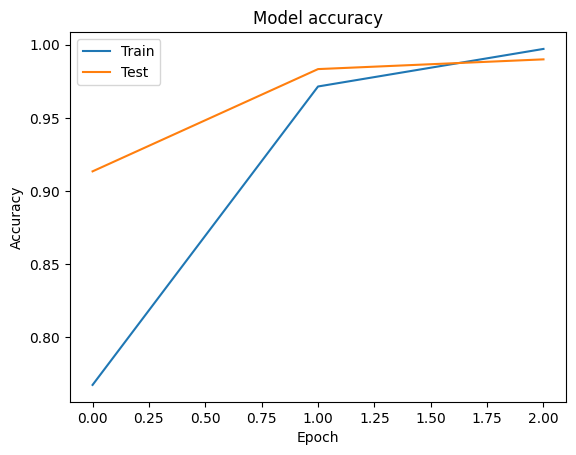

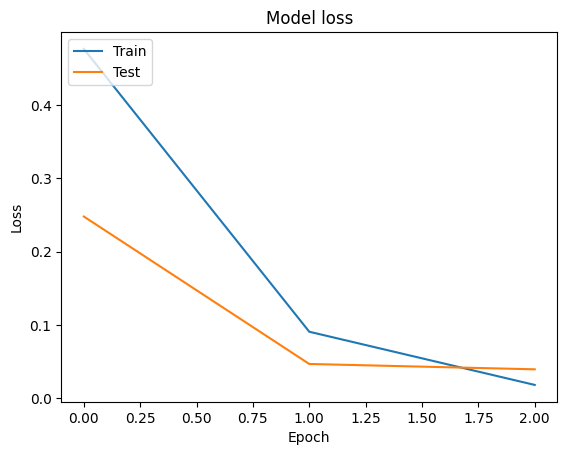

In [48]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [49]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_119 (Dropout)       multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
fake_news_1 = '''
In a shocking revelation, scientists at NASA have announced the discovery of an alien civilization living beneath the surface of Mars.
The report claims that a recent Mars rover mission captured clear images of extraterrestrial life forms and their advanced underground city. 
However, there has been no independent verification of these findings, and experts from other space agencies have expressed skepticism about the claims.
'''
fake_news_2 = '''
A viral article claims that due to a rare chemical reaction caused by global warming, the world's oceans are set to turn into lemonade within the next decade.
The story cites a study from a non-existent institute and includes quotes from so-called experts who cannot be traced. Oceanographers and climate scientists
have debunked this story, calling it a complete fabrication.
'''
fake_news_3 = '''
According to a widely shared post, New York City has announced a plan to replace all its public transportation with flying cars within the next two years.
The article includes statements from fictional city officials and fake renderings of flying vehicles. Transportation authorities in New York have dismissed
the story as a hoax.
'''

real_news_1 = '''
NASA's Perseverance rover successfully landed on Mars, as part of the Mars 2020 mission to search for signs of past life and collect samples of Martian rock
and regolith (broken rock and soil). The successful landing was a significant achievement for space exploration, and the rover's findings could provide critical
insights into the planet's history.
'''
real_news_2 = '''
According to a report by the International Energy Agency, global carbon dioxide emissions reached a record high in 2022, driven largely by increased energy use
and the continued reliance on fossil fuels. The report highlights the challenges facing the international community in its efforts to combat climate change.
'''
real_news_3 = '''
Multiple COVID-19 vaccines, including those developed by Pfizer-BioNTech, Moderna, and AstraZeneca, have shown high efficacy in clinical trials and are being
rolled out globally. These vaccines represent a significant step forward in the fight against the COVID-19 pandemic, with millions of doses being administered
worldwide.
'''

In [56]:

random_input = fake_news_3
random_input = tokenizer.encode_plus(
    random_input,
    add_special_tokens=True,
    max_length=512,
    truncation = True,
    padding='max_length', 
    return_attention_mask=True,
    return_tensors="tf"
)

input_ids = random_input['input_ids']
attention_mask = random_input['attention_mask']


predictions = model(input_ids, attention_mask=attention_mask)
probabilities = tf.nn.softmax(predictions.logits, axis=-1)


predicted_class = tf.argmax(probabilities, axis=-1).numpy()

class_names = ['Real', 'Fake']
print(f"The article is predicted as: {class_names[predicted_class[0]]}")

print(f"Probabilities per class: {probabilities.numpy()[0]}")

The article is predicted as: Real
Probabilities per class: [0.85035753 0.14964247]
